# DS1003 Machine Learning HW1 Code 
## Zian Jiang

## Q1

Since it is indepedent from the traing set, the validation set is used to compare performances of different parameters and decide to select a model among different models and prevent overfitting. If the model is trained by the training set only, without the validation set, the model may get 100\% accuracy and overfit. We need validation set to see the generalization of the model.

## Q2: Transforming data

In [1]:
! pip install pandas

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [2]:
import os
import sys
import collections
import re
import copy
import pandas as pd
import numpy as np

In [3]:
with open('spam_train.txt','r') as text_file:
    corpus = text_file.readlines()

In [4]:
len(corpus)

5000

In [5]:
train_raw = corpus[:4000]
val_raw = corpus[4000:]

In [6]:
temp_train_labels = [int(text[0]) for text in train_raw]
temp_val_labels = [int(text[0]) for text in val_raw]

In [7]:
train_labels = [1 if label else -1 for label in temp_train_labels]
val_labels = [1 if label else -1 for label in temp_val_labels]

In [8]:
train_raw = [text[2:] for text in train_raw]
val_raw = [text[2:] for text in val_raw]

In [9]:
MIN_FREQUENCY = 30

In [10]:
from tqdm import tqdm

In [11]:
def tokenize(sent):  
    return [word.lower() for word in sent.split(" ")]

tokenize("machine learning nyu")

['machine', 'learning', 'nyu']

In [ ]:
def tokenize_dataset(raw_data):
    token_dataset = []
    all_unique_tokens = []
    for sent in tqdm(raw_data):
        tokens = tokenize(sent)
        token_dataset.append(tokens)
        for token in tokens:
            if token not in all_unique_tokens:
                all_unique_tokens.append(token)
    return token_dataset, all_unique_tokens

token_train, vocab = tokenize_dataset(train_raw)



  9%|▉         | 369/4000 [00:22<00:24, 145.63it/s]

In [13]:
len(vocab)

55868

In [12]:
train_labels = np.asarray(train_labels)
val_labels = np.asarray(val_labels)

In [16]:
def build_vocab(vocab,token_dataset,min_frequency):
    frequent_tokens = []
    rest = []
    
    for word in tqdm(vocab):
        count = 0
        for tokens in token_dataset:
            if word in tokens:
                count += 1
        if count >= 30:
            frequent_tokens.append(word)
        else:
            rest.append(word)        
    return frequent_tokens, rest
        
frequent_vocab,rest = build_vocab(vocab,token_train,MIN_FREQUENCY)
    

100%|██████████| 55868/55868 [27:27<00:00, 33.92it/s]


In [17]:
np.save("vocab.npy",frequent_vocab)
len(frequent_vocab)

2375

In [18]:
def vectorize(token_dataset,vocab):
    vecs = []
    for sentence in tqdm(token_dataset):
        sent_vec = []
        for token in vocab:
            if token in sentence:
                sent_vec.append(1)
            else:
                sent_vec.append(0)
        vecs.append(sent_vec)
    return np.asarray(vecs)

frequent_vocab = np.load("vocab.npy")
X_train = vectorize(token_train,frequent_vocab)
np.save("X_train.npy",X_train)

token_val, _ = tokenize_dataset(val_raw)
X_val = vectorize(token_val,frequent_vocab)
np.save("X_val.npy",X_val)

100%|██████████| 1000/1000 [00:17<00:00, 57.13it/s]


## Q3: Perceptron implementation

In [13]:
frequent_vocab = np.load("vocab.npy")
X_train = np.load("X_train.npy")
X_val = np.load("X_val.npy")

In [14]:
def perceptron_train(data,y):
    n,d = data.shape
    w = np.zeros(d)
    k = 0
    iter_ = 0
    while True:
        temp = 0
        for row_idx in tqdm(range(data.shape[0])):
            data_point = data[row_idx]
            if sum(data_point) != 0:
                if y[row_idx] * w.dot(data_point) <= 0:
                    temp += 1
                    k += 1
                    w += y[row_idx] * data_point
        if temp == 0:
            return w,k,iter_
        else:
            iter_ += 1
        
def perceptron_test(w,data,y):
    num_errors = 0
    for row_idx in range(data.shape[0]):
        data_point = data[row_idx]
        if y[row_idx] * w.dot(data_point) < 0:
            num_errors += 1
    return float(num_errors/y.shape[0])

## Q4

In [15]:
w,num_mistakes,num_passes = perceptron_train(X_train,train_labels)
print(num_mistakes," mistakes were made before the algorithm terminated.")

100%|██████████| 4000/4000 [00:02<00:00, 1603.56it/s]

419  mistakes were made before the algorithm terminated.


In [16]:
print("Training error: ", perceptron_test(w,X_train,train_labels))

Training error:  0.0


In [17]:
print("Validation error: ",perceptron_test(w,X_val,val_labels))

Validation error:  0.019


## Q5

In [18]:
print("15 words with most positive weights: ", [frequent_vocab[i] for i in w.argsort()[::-1][:15]])

15 words with most positive weights:  ['sight', 'market', 'click', 'remov', 'deathtospamdeathtospamdeathtospam', 'our', 'present', 'further', 'hour', 'these', 'yourself', 'pleas', 'guarante', 'bodi', 'promot']


In [19]:
print("15 words with most negative weights: ", [frequent_vocab[i] for i in w.argsort()[:15]])

15 words with most negative weights:  ['wrote', 'i', 'server', 'messag', 'inc', 'sinc', 'run', 'url', 'recipi', 'copyright', 'on', 'chang', 'standard', 'set', 'which']


## Q6

In [20]:
def averaged_perceptron(data,y):
    n,d = data.shape
    w = np.zeros(d)
    a = np.zeros(d)
    k = 0
    iter_ = 0
    count = 0
    while True:
        temp = 0
        for row_idx in tqdm(range(data.shape[0])):
            data_point = data[row_idx]
            if sum(data_point) != 0:
                if y[row_idx] * w.dot(data_point) <= 0:
                    temp += 1
                    k += 1
                    w += y[row_idx] * data_point
                    a += w
                    count += 1
                else:
                    a += w
                    count += 1
        if temp == 0:
            return a/count,k,iter_
        else:
            iter_ += 1

a,num_mistakes,num_passes = averaged_perceptron(X_train,train_labels)
print(num_mistakes," mistakes were made before the algorithm terminated.")
print("Validation error: ",perceptron_test(a,X_val,val_labels))

100%|██████████| 4000/4000 [00:02<00:00, 1522.80it/s]

419  mistakes were made before the algorithm terminated.
Validation error:  0.016


## Q7

In [21]:
import matplotlib.pyplot as plt
N = [100, 200, 400, 800, 2000, 4000]
p_errors = []
avg_errors = []
p_epochs = []
avg_epochs = []

for n in N:
    print("Training N = ",n)
    X_new_train = X_train[:n]
    X_new_val = np.concatenate((X_train[n::],X_val))
    new_train_labels = train_labels[:n]
    new_val_labels = np.concatenate((train_labels[n::],val_labels))
    
    a,num_mistakes,num_passes = averaged_perceptron(X_new_train,new_train_labels)
    avg_errors.append(perceptron_test(a,X_new_val,new_val_labels))
    avg_epochs.append(num_passes)
    
    w,num_mistakes_,num_passes_ = perceptron_train(X_new_train,new_train_labels)
    p_errors.append(perceptron_test(w,X_new_val,new_val_labels))
    p_epochs.append(num_passes_)

  0%|          | 0/100 [00:00<?, ?it/s]

Training N =  100


  0%|          | 0/200 [00:00<?, ?it/s]

Training N =  200


 47%|████▋     | 188/400 [00:00<00:00, 1869.76it/s]

Training N =  400


 16%|█▌        | 126/800 [00:00<00:00, 1253.02it/s]

Training N =  800


  5%|▌         | 108/2000 [00:00<00:01, 1071.52it/s]

Training N =  2000


  5%|▍         | 186/4000 [00:00<00:02, 1853.21it/s]

Training N =  4000


100%|██████████| 4000/4000 [00:02<00:00, 1595.10it/s]


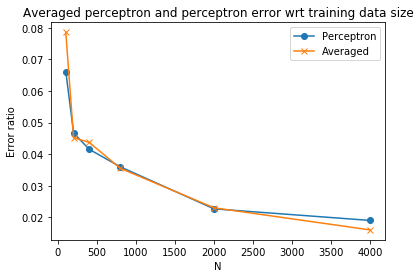

In [22]:
def plot_val_error(p_errors,avg_errors,N):
    plt.plot(N,p_errors,"o-",label = "Perceptron")
    plt.plot(N,avg_errors,"-x",label = "Averaged")
    plt.xlabel("N")
    plt.ylabel("Error ratio")
    plt.legend()
    plt.title("Averaged perceptron and perceptron error wrt training data size")
    
%matplotlib inline    
plot_val_error(p_errors,avg_errors,N)

## Q8

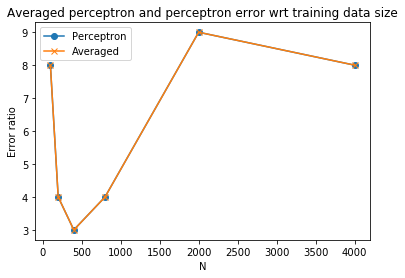

In [23]:
def plot_epochs(p_epochs,avg_epochs,N):
    plt.plot(N,p_epochs,"o-",label = "Perceptron")
    plt.plot(N,avg_epochs,"-x",label = "Averaged")
    plt.xlabel("N")
    plt.ylabel("Epochs")
    plt.legend()
    plt.title("Averaged perceptron and perceptron epochs wrt training data size")
    
%matplotlib inline    
plot_val_error(p_epochs,avg_epochs,N)

## Q9

In [24]:
def averaged_perceptron(data,y,MAX_ITER):
    n,d = data.shape
    w = np.zeros(d)
    a = np.zeros(d)
    k = 0
    iter_ = 0
    count = 0
    for _ in range(MAX_ITER):
        temp = 0
        for row_idx in tqdm(range(data.shape[0])):
            data_point = data[row_idx]
            if sum(data_point) != 0:
                if y[row_idx] * w.dot(data_point) <= 0:
                    temp += 1
                    k += 1
                    w += y[row_idx] * data_point
                    a += w
                    count += 1
                else:
                    a += w
                    count += 1
        if temp == 0:
            return a/count,k,iter_
        else:
            iter_ += 1        
    return a/count,k,iter_
            
    
def perceptron_train(data,y,MAX_ITER):
    n,d = data.shape
    w = np.zeros(d)
    k = 0
    iter_ = 0
    for _ in range(MAX_ITER):
        temp = 0
        for row_idx in tqdm(range(data.shape[0])):
            data_point = data[row_idx]
            if sum(data_point) != 0:
                if y[row_idx] * w.dot(data_point) <= 0:
                    temp += 1
                    k += 1
                    w += y[row_idx] * data_point
        if temp == 0:
            return w,k,iter_
        else:
            iter_ += 1        
    return w,k,iter_

In [26]:
MAX_ITERS = range(1,11)
p_errors = []
avg_errors = []

for MAX_ITER in MAX_ITERS:
    print("Training with max number of iterations: ", MAX_ITER)
    w,_,_ = perceptron_train(X_train,train_labels,MAX_ITER)
    p_errors.append(perceptron_test(w,X_val,val_labels))
    a,_,_ = averaged_perceptron(X_train,train_labels,MAX_ITER)
    avg_errors.append(perceptron_test(a,X_val,val_labels))



  4%|▍         | 175/4000 [00:00<00:02, 1747.29it/s]

Training with max number of iterations:  1



100%|██████████| 4000/4000 [00:02<00:00, 1529.20it/s]

100%|██████████| 4000/4000 [00:03<00:00, 1216.22it/s]

  2%|▏         | 98/4000 [00:00<00:04, 974.41it/s]

Training with max number of iterations:  2



100%|██████████| 4000/4000 [00:02<00:00, 1621.83it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1628.33it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1513.04it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1591.57it/s]

  2%|▏         | 99/4000 [00:00<00:03, 981.96it/s]

Training with max number of iterations:  3



100%|██████████| 4000/4000 [00:02<00:00, 1450.39it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1627.88it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1569.52it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1659.74it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1679.49it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1746.89it/s]

  4%|▍         | 168/4000 [00:00<00:02, 1675.40it/s]

Training with max number of iterations:  4



100%|██████████| 4000/4000 [00:02<00:00, 1634.87it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1581.63it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1617.50it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1623.63it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1513.45it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1531.78it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1595.14it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1636.58it/s]

  5%|▍         | 189/4000 [00:00<00:02, 1882.35it/s]

Training with max number of iterations:  5



100%|██████████| 4000/4000 [00:02<00:00, 1528.17it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1570.46it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1571.25it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1617.59it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1452.52it/s]

100%|██████████| 4000/4000 [00:03<00:00, 1208.83it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1521.13it/s]

100%|██████████| 4000/4000 [00:03<00:00, 1290.27it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1419.19it/s]

100%|██████████| 4000/4000 [00:03<00:00, 1214.37it/s]

  2%|▏         | 95/4000 [00:00<00:04, 940.33it/s]

Training with max number of iterations:  6



100%|██████████| 4000/4000 [00:04<00:00, 822.15it/s]

100%|██████████| 4000/4000 [00:05<00:00, 698.61it/s]

100%|██████████| 4000/4000 [00:05<00:00, 734.29it/s]

100%|██████████| 4000/4000 [00:05<00:00, 691.19it/s]

100%|██████████| 4000/4000 [00:07<00:00, 550.01it/s]

100%|██████████| 4000/4000 [00:04<00:00, 966.45it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1499.84it/s]

100%|██████████| 4000/4000 [00:03<00:00, 1030.52it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1524.38it/s]

100%|██████████| 4000/4000 [00:03<00:00, 1142.00it/s][A

100%|██████████| 4000/4000 [00:03<00:00, 1169.62it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1551.00it/s]

  4%|▍         | 174/4000 [00:00<00:02, 1735.84it/s]

Training with max number of iterations:  7



100%|██████████| 4000/4000 [00:02<00:00, 1506.22it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1576.62it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1401.32it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1564.42it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1576.41it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1611.87it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1555.07it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1611.34it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1554.13it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1553.89it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1548.86it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1556.90it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1564.11it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1527.48it/s]

  4%|▍         | 180/4000 [00:00<00:02, 1797.49it/s]

Training with max number of iterations:  8



100%|██████████| 4000/4000 [00:02<00:00, 1569.89it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1624.89it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1649.16it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1583.54it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1485.21it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1561.49it/s]

100%|██████████| 4000/4000 [00:03<00:00, 1310.18it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1511.39it/s]

100%|██████████| 4000/4000 [00:03<00:00, 1267.25it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1554.27it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1562.73it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1451.22it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1525.26it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1571.57it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1608.56it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1494.99it/s]

  5%|▍         | 192/4000 [00:00<00:01, 1914.10it/s]

Training with max number of iterations:  9



100%|██████████| 4000/4000 [00:02<00:00, 1645.95it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1475.02it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1460.46it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1463.24it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1494.78it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1539.70it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1559.03it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1568.26it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1536.69it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1579.34it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1535.96it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1548.80it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1546.77it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1553.45it/s]

100%|██████████| 4000/4000 [00:03<00:00, 1283.40it/s]

100%|██████████| 4000/4000 [00:03<00:00, 1298.62it/s][A

100%|██████████| 4000/4000 [00:02<00:00, 1459.24it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1372.80it/s]

  5%|▌ 

Training with max number of iterations:  10



100%|██████████| 4000/4000 [00:02<00:00, 1620.17it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1644.63it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1623.69it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1599.32it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1636.32it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1626.15it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1629.94it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1522.55it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1549.12it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1593.89it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1507.72it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1556.19it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1554.44it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1562.47it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1605.38it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1481.88it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1563.53it/s]

100%|██████████| 4000/4000 [00:02<00:00, 1503.89it/s]


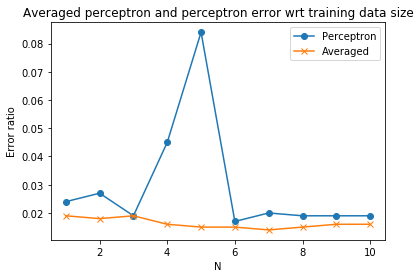

In [28]:
plot_val_error(p_errors,avg_errors,MAX_ITERS)

In [29]:
print("The best setup is Averaged Perceptron with max 7 passes of the data, which achieves error on validation set: ", avg_errors[6])

The best setup is Averaged Perceptron with max 7 passes of the data, which achieves error on validation set:  0.014


## Q11

In [41]:
with open('spam_test.txt','r') as text_file:
    corpus = text_file.readlines()

temp_test_labels = [int(text[0]) for text in corpus]
test_labels = [1 if label else -1 for label in temp_test_labels]

test_raw = [text[2:] for text in corpus]

def tokenize_dataset(raw_data):
    token_dataset = []
    all_unique_tokens = []
    for sent in raw_data:
        tokens = tokenize(sent)
        token_dataset.append(tokens)
        for token in tokens:
            if token not in all_unique_tokens:
                all_unique_tokens.append(token)
    return token_dataset, all_unique_tokens

token_test, _ = tokenize_dataset(test_raw)

def vectorize(token_dataset,vocab):
    vecs = []
    for sentence in token_dataset:
        sent_vec = []
        for token in vocab:
            if token in sentence:
                sent_vec.append(1)
            else:
                sent_vec.append(0)
        vecs.append(sent_vec)
    return np.asarray(vecs)

X_test = vectorize(token_test,frequent_vocab)
np.save("X_test.npy",X_test)





 28%|██▊       | 275/1000 [00:22<00:11, 61.36it/s]

In [64]:
%%capture
X_test = np.load("X_test.npy")
a,_,_ = averaged_perceptron(X_train,train_labels,7)

In [65]:
print("Test set error: ", perceptron_test(a,X_test,np.array(test_labels)))

Test set error:  0.015
